# Missing data patterns

Are there concerning patterns in missingness? In particular, does missingness change pre-post pandemic?

In [1]:
using DataFrames
using DataFramesMeta
using Plots
using StatsBase
using StatsModels
using Dates
using Plots.PlotMeasures
using GLM
using CSV
using CategoricalArrays
using Distributions
using Tables
using Revise
using LaTeXStrings
using Pipe
using CovarianceMatrices
using Distributions

In [2]:
using KFactors

In [3]:
raw_data = read_data("../data/peaks_merged.parquet", dropmissing=false)
nothing

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.83%)
└ @ KFactors /Users/mwbc/git/peak-spreading/src/computation.jl:65


In [12]:
data = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022, min_complete=0.0);

## Reasons for missingness

There are multiple ways data can be missing:
1. It can have small gaps that are imputed (e.g. because the modem failed to upload for a few minutes)
2. It can have large gaps or full days that are imputed
3. There can be insufficient data - we don't complete or imputed records for the full sensor day
4. There can be no traffic
5. (handled below) The sensor could not be in the file for that day, though it appears in other files

## Temporal patterns in missingness

Did the reasons why data was missing change over the study period? Note that the plot only shows the active study period in each year.

In [14]:
function plot_missingness(data)
    data[!, :missing_reason] .= :not_missing
    data[data.periods_imputed .> 0, :missing_reason] .= :imputed_less_than_1hr
    data[data.periods_imputed .>= 12, :missing_reason] .= :imputed_1hr_or_more
    data[ismissing.(data.peak_hour_occ), :missing_reason] .= :insufficient_data
    data[coalesce.(data.total_occ .== 0, [false]), :missing_reason] .= :no_traffic
    
    sensors = unique(data.station)
    dates = unique(data.date)
    sensor_days = reshape(collect(Iterators.product(sensors, dates)), :)
    sensor_df = DataFrame(station=map(x -> x[1], sensor_days), date=map(x -> x[2], sensor_days))
    nothing
    data = leftjoin(sensor_df, data, on=[:station, :date])
    
    data[ismissing.(data.missing_reason), :missing_reason] .= :not_in_file

    # temporal patterns in missingness
    temporal_missingness = combine(groupby(data, :date),
        :missing_reason => (x -> sum(x .== :imputed_less_than_1hr)) => :sensors_imputed_less_than_1hr,
        :missing_reason => (x -> sum(x .== :imputed_1hr_or_more)) => :sensors_imputed_1hr_or_more,
        :missing_reason => (x -> sum(x .== :no_traffic)) => :sensors_no_traffic,
        :missing_reason => (x -> sum(x .== :insufficient_data)) => :sensors_insufficient_data,
        :missing_reason => (x -> sum(x .== :not_in_file)) => :sensors_not_in_file,
        :missing_reason => (x -> sum(x .== :not_missing)) => :sensors_not_missing,
        :missing_reason => length => :n
    )
    sort!(temporal_missingness, :date)

    areaplot(1:nrow(temporal_missingness),
        hcat(
            temporal_missingness.sensors_not_missing,
            temporal_missingness.sensors_imputed_less_than_1hr,
            temporal_missingness.sensors_imputed_1hr_or_more,
            temporal_missingness.sensors_no_traffic,
            temporal_missingness.sensors_insufficient_data,
            temporal_missingness.sensors_not_in_file
        ),
        label=["not missing" "imputed < 1 hour" "imputed ≥ 1 hour" "no traffic" "insufficient data" "not in file"],
        legend=:outertopright,
        xticks=false,
        ylabel="Number of sensors",
        size=(800, 300),
        left_margin=50px,
        ylim=(0, temporal_missingness.n[1])
    )

    year_boundaries = map([2016, 2017, 2018, 2019, 2020, 2022]) do y
        return sum(temporal_missingness.date .< Date(y, 1, 1))
    end

    vline!(year_boundaries, color=:white, label=false)
    annotate!(zip(year_boundaries .+ 10, fill(150, 6), map([2016, 2017, 2018, 2019, "2020-21", 2022]) do y 
                text(y, :white, :hleft, pointsize=8)
            end)...)

    return data, plot!()
end

plot_missingness (generic function with 1 method)

In [15]:
data2, plot_all = plot_missingness(data)
savefig("../fig/sensor_missingness_all.pdf")

In [16]:
data_used = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022)
data_used, plot_used = plot_missingness(data_used)
savefig("../fig/sensor_missingness_used.pdf")

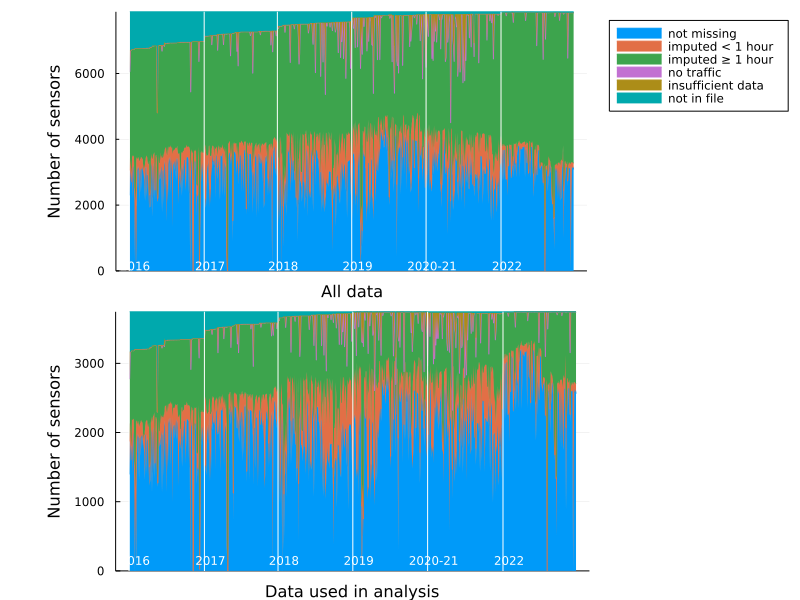

In [17]:
plot!(plot_all, xlabel="All data")
plot!(plot_used, legend=false, xlabel="Data used in analysis")
plot(plot_all, plot_used, plot(xticks=false, yticks=false, xaxis=false, yaxis=false), size=(800, 600), layout=@layout [
        a{1.0w}
        [b{0.73w} c{0.27w}]
    ])

# plot(plot_all, plot_used,size=(600, 800), layout=@layout [
#         a{0.4h}
#         b{0.6h}
#         ])

savefig("../fig/sensor_missingness.pdf")
plot!()

In [18]:
@pipe groupby(data, :missing_reason) |> combine(_, x -> nrow(x) / nrow(data))

,missing_reason,x1
,Symbol,Float64
1,not_missing,0.390075
2,imputed_1hr_or_more,0.486847
3,imputed_less_than_1hr,0.102067
4,no_traffic,0.00068185
5,insufficient_data,0.0203291
